In [1]:
#imports
import random as rd
import numpy as np
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
en = 3
ch = 3
tol = 0.2
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
# P = row_normalize(np.random.rand(ch,ch))
# E = np.random.rand(ch,ch)
rate = np.array([8.,4.,6.])
lr = 0.01
print(P)
print(E)

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]


In [4]:
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(0)
step = 10
t = 0

In [5]:
T = 10000
sprob = steady_state_prob(p[-1])
while t < T:
    enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    if (t+1)%step == 0:
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        step_emiss = np.sum(np.transpose([lamda[-1]])*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]])
        # progressive update
        temp = np.copy(p[-1])
        temp = temp + lr*(model.transmat_-temp)
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        lamda.append(ltemp.x)
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,rate))
        print(t,emp_rate[-1],ltemp.success)
    t+=1

9 4.00750858491395 True
19 4.007264931231438 True
29 4.00702749354221 True
39 4.000403853088377 True
49 4.000155923021966 True
59 3.9998618726712647 True
69 4.0045515243678125 True
79 4.009155041875275 True
89 4.014826296449886 True
99 4.014579814527188 True
109 4.007642411476532 True
119 4.012286346995469 True
129 4.007072799757649 True
139 4.006818772309153 True
149 3.9995208031139695 True
159 4.004366203280847 True
169 4.009082204794276 True
179 4.00886260897148 True
189 4.008643255327405 True
199 4.021238613675609 True
209 4.020981900099224 True
219 4.020725411269812 True
229 4.0149265732867185 True
239 4.019632925641312 True
249 4.0126710965214745 True
259 4.012386359006027 True
269 4.017143742349482 True
279 4.0093151384337204 True
289 4.002758094041614 True
299 4.015417345179436 True
309 4.008411840995861 True
319 4.008188247312486 True
329 4.012949214719317 True
339 4.012666414763672 True
349 4.018450581734693 True
359 4.01123269611589 True
369 4.023923944955975 True
379 4.0117

In [6]:
# print(p[0])
print('estimated trans\n',p[-1])
print('real trans\n',P)
print('lamda\n',lamda[-1])
# print(sprob)
# print(model.transmat_)

estimated trans
 [[0.02832573 0.41909366 0.55258061]
 [0.02947198 0.39018127 0.58034675]
 [0.03080659 0.40656287 0.56263054]]
real trans
 [[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
lamda
 [0.05634599 0.94365401 0.        ]


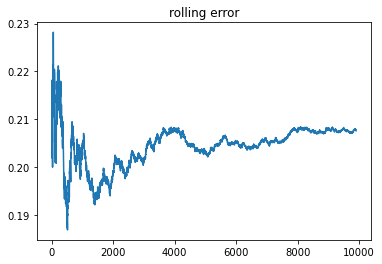

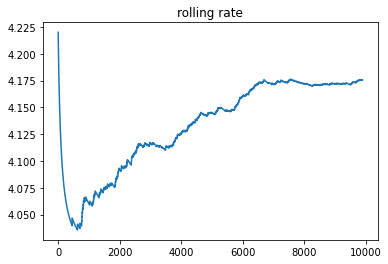

In [7]:
stat = 100
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('rolling error')
plt.show()
rate_plot = [0]
for i in range(1,len(enc)):
    rate_plot.append((rate_plot[i-1]*(i-1))+rate[enc[i]])
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('rolling rate')
plt.show()

In [8]:
print(rate_plot[-1],error_plot[-1])

4.175400000000045 0.20759999999999978


24.9295467229741


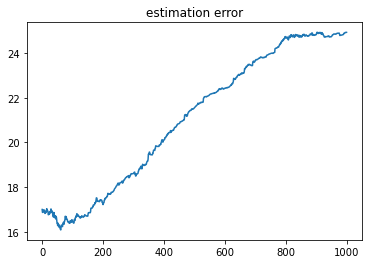

In [9]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))/s)*100)
print(err[-1])
plt.plot(err)
plt.title('estimation error')
plt.show()

0.18360655737704915
4.218579234972678 1.0 [0.] True 0.2
4.225383940093444


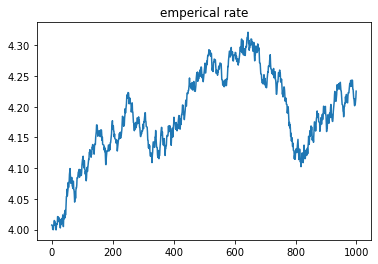

In [10]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))
print(emp_rate[-1])
plt.plot(emp_rate[1:])
plt.title('emperical rate')
plt.show()

[0.03019732 0.40038236 0.56942032]
[0.29508197 0.2704918  0.43442623]
18.73133175166048


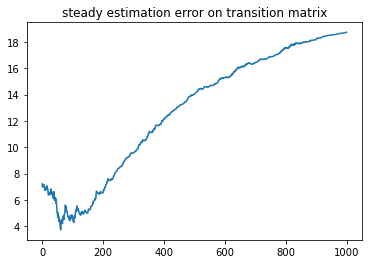

In [11]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(i)))/3)*100)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show()

In [23]:
# reference
model = hmm.MultinomialHMM(n_components=3, algorithm='viterbi', params='t', init_params='t',n_iter=1000, tol=1.0e-3)
model.emissionprob_ = [[E[0][0],1.0-E[0][0]],[E[0][1],1.0-E[0][1]],[E[0][2],1.0-E[0][2]]]
model.startprob_ = np.ones(ch)/ch
model.fit([b])
print(model.emissionprob_,model.startprob_)
print(model.transmat_,P)
s = np.shape(P)[0]*np.shape(P)[1]
print('Error',np.sqrt(np.sum(np.square(P-model.transmat_))/s)*100)